<h4>Concept Extraction and Word Embeddings</h4>

Problem:  

   Find relationships between Disease or Syndromes, Signs or Symptoms and Chemicals and Drugs and Anatomy parts in Pubmed Articles on Type I Diabetes.

Solution:
   
   Using [BioPython] (http://biopython.org/DIST/docs/tutorial/Tutorial.html) we're searching Pubmed for articles oin Type I Diabetes. 

   We're extracting medical terms using UMLS (an ontlogy) utilizing QuickUMLS (a Spacy based library) and we filter the content of the articles on just these two semantic types.
   
   We're training Word2Vec on these filtered articles and we analyze the relationships computed based on these embedding vectors.
    

In [1]:
from __future__ import print_function
search_term = 'type+1+diabetes[MH]'
max_articles = 100

from Bio import Entrez
print('Searching PubMed abstracts for documents containing term: ',search_term)
handle = Entrez.esearch(db="pubmed", term=search_term, retmax=max_articles)
record = Entrez.read(handle)
handle.close()
idlist = record["IdList"]

print('Found:',len(idlist),' documents')

Searching PubMed abstracts for documents containing term:  type+1+diabetes[MH]
Found: 100  documents


In [2]:
#fetching the previously found documents
from Bio import Medline
handle = Entrez.efetch(db="pubmed", id=idlist, rettype="medline",retmode="text")
records = Medline.parse(handle)
data = []
for record in records:
    data.append((record.get("TI", "?"),record.get("AU", "?"),record.get("SO", "?"),record.get("AB","?")))
import pandas as pd
df = pd.DataFrame(data=data, columns=['Title','Authors','Source','Abstract'])
df.head(10)

,Title,Authors,Source,Abstract
0,Presence of Peripheral Neuropathy Is Associate...,"[Dehghani C, Srinivasan S, Edwards K, Pritchar...",Invest Ophthalmol Vis Sci. 2017 May 1;58(6):BI...,Purpose: Reduced retinal nerve fiber layer (RN...
1,Analysis of Cone Mosaic Reflectance Properties...,"[Mariotti L, Devaney N, Lombardo G, Lombardo M]",Invest Ophthalmol Vis Sci. 2017 Aug 1;58(10):4...,Purpose: We investigate the reflectance proper...
2,Mesenchymal Stem Cells Promote Diabetic Cornea...,"[Di G, Du X, Qi X, Zhao X, Duan H, Li S, Xie L...",Invest Ophthalmol Vis Sci. 2017 Aug 1;58(10):4...,Purpose: To explore the role and mechanism of ...
3,[Pharmacological approaches for correction of ...,[Shpakov AO],Biomed Khim. 2017 May;63(3):219-231. doi: 10.1...,Thyroid diseases are closely associated with t...
4,Prediction of glycaemic control in young child...,"[van Esdonk MJ, Tai B, Cotterill A, Charles B,...",PLoS One. 2017 Aug 2;12(8):e0182181. doi: 10.1...,OBJECTIVES: Glycaemic control in children and ...
5,Childhood adiposity and risk of type 1 diabete...,"[Censin JC, Nowak C, Cooper N, Bergsten P, Tod...",PLoS Med. 2017 Aug 1;14(8):e1002362. doi: 10.1...,BACKGROUND: The incidence of type 1 diabetes (...
6,Retinal Vessel Geometry and the Incidence and ...,"[Lim LS, Chee ML, Cheung CY, Wong TY]",Invest Ophthalmol Vis Sci. 2017 May 1;58(6):BI...,Purpose: To analyze the associations between r...
7,More on Intralymphatic Injection of Autoantige...,"[Haller M, Atkinson M, Schatz D]",N Engl J Med. 2017 Jul 27;377(4):403. doi: 10....,?
8,More on Intralymphatic Injection of Autoantige...,"[Ludvigsson J, Tavira B, Casas R]",N Engl J Med. 2017 Jul 27;377(4):403-5. doi: 1...,?
9,Xanthohumol Restores Hepatic Glucolipid Metabo...,"[Lima-Fontes M, Costa R, Rodrigues I, Soares R]",J Agric Food Chem. 2017 Aug 30;65(34):7433-743...,"Diabetes exhibits increased inflammation, angi..."


Using https://github.com/Georgetown-IR-Lab/QuickUMLS extract concepts out of these articles

In [3]:
import sys
sys.path.append('QuickUMLS')
from quickumls import QuickUMLS
tagger = QuickUMLS('QuickUMLS/data')

In [4]:
print(tagger)
print(tagger.nlp)
for obj in tagger.nlp.pipeline:
    print('\t',obj)

In [5]:
#Load the complete list of Semantic Types available in UMLS
sems = {}
data=[]
with open('SemGroups_2013.txt','r') as f:
    for line in f:
        lines = line.replace('\n','').split('|')
        cat = lines[1]
        semtype = lines[2]
        desc = lines[3]
        sems[semtype]=(cat,desc)
        data.append([semtype,cat,desc])
import pandas as pd
sdf = pd.DataFrame(data=data,columns=['SemType','Category','Tag'])
sdf

,SemType,Category,Tag
0,T052,Activities & Behaviors,Activity
1,T053,Activities & Behaviors,Behavior
2,T056,Activities & Behaviors,Daily or Recreational Activity
3,T051,Activities & Behaviors,Event
4,T064,Activities & Behaviors,Governmental or Regulatory Activity
5,T055,Activities & Behaviors,Individual Behavior
6,T066,Activities & Behaviors,Machine Activity
7,T057,Activities & Behaviors,Occupational Activity
8,T054,Activities & Behaviors,Social Behavior
9,T017,Anatomy,Anatomical Structure


In [23]:
#Extract medical concepts out of the first article
txt = unicode('\n\n'+df['Abstract'].values[0])
# print(txt)
tagger.window = 5 #window used by the tagger to construct n grams from tokens
matches= tagger.match(txt, best_match=True, ignore_syntax=False)

stpwds = set()
doc = tagger.nlp(txt)
for token in doc:
    if token.is_stop:
        stpwds.add(token.idx)
        
    
import pandas as pd
tagged = {}
data = []
for match in matches:
#     print match
    semtypes = set()
    term = ''
    cui = ''
    ngram = ''
    mi=0
    for m in match:
        for s in m['semtypes']:
            semtypes.add(s)
        if m['similarity']>mi:
            term = m['term']
            cui = m['cui']
            mi=m['similarity']
            ngram = m['ngram']
    if len(term)<=2:
        continue
    if match[0]['start'] in stpwds:
        continue
    tmp=[]
    tmp.append(match[0]['start'])
    tmp.append(match[0]['end'])
    tmp.append(term)
    tmp.append(cui)
    tmp.append(mi)
    stypes = set()
    for sem in semtypes:
        stypes.add(sems[sem][1])
    tmp.append(stypes)
    tagged[term]=stypes
    data.append(tmp)
    
df_matches = pd.DataFrame(data=data, columns =['start','end','term','cui','similarity','semtypes'])
import helper_methods
# reload(helper_methods)
html = helper_methods.generate_html(tagged,sems)
tmp = txt
for tk in tagged:
    for tag in tagged[tk]:
        tmp = tmp.replace(tk,'<mark data-entity="'+tag.replace(' ','_').replace(',','_').replace('&','_and_')+'">'+tk+'</mark>')
html+=tmp
html+='</div>'
from IPython.display import display,HTML
display(HTML(html))
display(df_matches)

,start,end,term,cui,similarity,semtypes
0,101,131,diabetic peripheral neuropathy,C0740447,1.000000,"{Clinical Attribute, Disease or Syndrome}"
1,549,577,optical coherence tomography,C0920367,1.000000,"{Finding, Diagnostic Procedure, Medical Device}"
2,506,522,photocoagulation,C0023694,1.000000,{Therapeutic or Preventive Procedure}
3,680,696,optic nerve head,C0029127,1.000000,"{Finding, Body Part, Organ, or Organ Component}"
4,264,279,type 1 diabetes,C0011854,1.000000,"{Finding, Disease or Syndrome}"
5,411,426,type 1 diabetes,C0011854,1.000000,"{Finding, Disease or Syndrome}"
6,1484,1499,body mass index,C0005893,1.000000,"{Finding, Clinical Attribute, Diagnostic Proce..."
7,1428,1442,blood pressure,C0005823,1.000000,"{Disease or Syndrome, Clinical Attribute, Heal..."
8,338,350,risk factors,C1553898,1.000000,"{Finding, Intellectual Product}"
9,355,367,nerve damage,C0161479,1.000000,{Injury or Poisoning}


In [ ]:
# this cell contains the code for a helper function that generates HTML code to highlight the 
# extracted words along with their semantic types in UMLS

# %%writefile helper_methods.py
# import random
# def get_random_color(pastel_factor = 0.5):
#     return [(x+pastel_factor)/(1.0+pastel_factor) for x in [random.uniform(0,1.0) for i in [1,2,3]]]

# def color_distance(c1,c2):
#     return sum([abs(x[0]-x[1]) for x in zip(c1,c2)])

# def generate_new_color(existing_colors,pastel_factor = 0.5):
#     max_distance = None
#     best_color = None
#     for i in range(0,100):
#         color = get_random_color(pastel_factor = pastel_factor)
#         if not existing_colors:
#             return color
#         best_distance = min([color_distance(color,c) for c in existing_colors])
#         if not max_distance or best_distance > max_distance:
#             max_distance = best_distance
#             best_color = color
#     return best_color
# def generate_html(tagged,sems):
#     html='''<style>
#    [data-entity] {
#     padding: 0.25em 0.35em;
#      margin: 0px 0.25em;
#      line-height: 1;
#      display: inline-block;
#      border-radius: 0.25em;
#      border: 0px solid;
#     }

# [data-entity]::after {
#     box-sizing: border-box;
#     content: attr(data-entity);
#     font-size: 0.9em;
#     line-height: 1;
#     padding: 0.35em;
#     border-radius: 0.35em;
#     text-transform: uppercase;
#     display: inline-block;
#     vertical-align: middle;
#     margin: 0px 0px 0.1rem 0.5rem;
#     }
#     '''
#     colors ={}

#     cols = []
#     for sem in sems:
#         tag_label = sems[sem][1].replace(' ','_').replace(',','_').replace('&','_and_')
#         colors[tag_label]=generate_new_color(cols,pastel_factor = 0.1)

#     for lbls in tagged.values():
#         for lbl in lbls:
#     #         print lbl
#             tag_label = lbl.replace(' ','_').replace(',','_').replace('&','_and_')
#             html+='''[data-entity][data-entity="'''+tag_label+'''"] {
#                     background: rgba('''+str(int(colors[tag_label][0]*255))+','+str(int(colors[tag_label][1]*255))+','+str(int(colors[tag_label][2]*255))+''', 0.6);
#                     border-color: rgb(166, 226, 45); 
#                     color:rgba(255,255,255,1.0);
#                     }\n'''


#     #         html+='[data-entity][data_entity="'+tag_label+'''"]::after {
#     #             background: rgba(66, '''+str(random.randint(0,255))+''', 45, 0.9);
#     #             }\n'''

#     html+='</style>'
#     html+='<div class = "mmm">'
#     return html

In [25]:
def process_document(id,txt,tagger):
    stpwds = set()
    #run the document through the NLP pipeline
    doc = tagger.nlp(txt)
    
    #create a list with the indeces of the stop words
    for token in doc:
        if token.is_stop:
            stpwds.add(token.idx)
    #run the UMLS tagger        
    matches= tagger.match(txt, best_match=True, ignore_syntax=True)
    data = []

    for match in matches:
        semtypes = set()
        term = ''
        cui = ''
        ngram = ''
        mi=0
        #for every match collect all the semantic types
        #keep only the term with the highest macthing score (similarity)
    
        for m in match:
            for s in m['semtypes']:
                semtypes.add(s)
            if m['similarity']>mi:
                term = m['term']
                cui = m['cui']
                mi=m['similarity']
                ngram = m['ngram']
                
        #filter out terms shorter than 3 chars
        if len(term)<=2:
            continue
        #filter out stop words
        if match[0]['start'] in stpwds:
            continue
            
        tmp=[]
        tmp.append(id)
        tmp.append(match[0]['start'])
        tmp.append(match[0]['end'])
        tmp.append(term.lower())
        tmp.append(cui)
        tmp.append(mi)
        stypes = set()
        for sem in semtypes:
            stypes.add(sems[sem][1])
        tmp.append(stypes)
        data.append(tmp)
    return data


#configure the UMLS tagger to anly accept certian Semantic Types (per our problem)
tagger.accepted_semtypes=set()
tagger.accepted_semtypes.add('T047') #Disease or Syndrome
tagger.accepted_semtypes.add('T184') # Sign or Symptom

for sem in sems:
    if sems[sem][0]=='Anatomy':
        tagger.accepted_semtypes.add(sem)
for sem in sems:
    if sems[sem][0]=='Chemicals & Drugs':
        tagger.accepted_semtypes.add(sem)

#Iterate over every document and extract the concepts
i=-1        
result = []
for idx,row in df.iterrows():
    try:
        i+=1
        if row['Abstract'] is None:
            continue
        annotations = process_document(i,unicode(row['Abstract']),tagger)
        result.extend(annotations)
    except Exception as e:
        print(e)
        
df_matches = pd.DataFrame(data=result, columns =['document','start','end','term','cui','similarity','semtypes'])
df_matches.sort_values(by=['document','start'],inplace=True)
df_matches

,document,start,end,term,cui,similarity,semtypes
10,0,17,24,retinal,C0035298,1.000000,"{Pharmacologic Substance, Vitamin, Body Part, ..."
4,0,25,36,nerve fiber,C0027749,1.000000,{Cell Component}
14,0,37,42,layer,C0934502,1.000000,"{Body Part, Organ, or Organ Component}"
0,0,99,129,diabetic peripheral neuropathy,C0740447,1.000000,{Disease or Syndrome}
2,0,262,277,type 1 diabetes,C0011854,1.000000,{Disease or Syndrome}
28,0,341,348,r factors,C0034471,0.538462,"{Nucleic Acid, Nucleoside, or Nucleotide, Biol..."
15,0,353,358,nerve,C0027740,1.000000,{Tissue}
3,0,409,424,type 1 diabetes,C0011854,1.000000,{Disease or Syndrome}
5,0,468,479,retinopathy,C0035309,1.000000,{Disease or Syndrome}
11,0,496,503,retinal,C0035298,1.000000,"{Pharmacologic Substance, Vitamin, Body Part, ..."


In [ ]:
# df_matches.to_pickle('df_matches_pubmed_diabetes_100.data')
# import pickle
# with open('df_matches_pubmed_diabetes_100.data','r') as f:
#     df_matches = pickle.load(f)

In [26]:
#construct documents using only the extracted concepts
data = []
for enc,items in df_matches.groupby(['document']):
    data.append((enc,'|'.join(items['term'].values)))
new_arts = pd.DataFrame(data = data,columns=['document','content'])
new_arts.head(5)

,document,content
0,0,retinal|nerve fiber|layer|diabetic peripheral ...
1,1,diabetic retinopathy|metrics|metrics|metric|re...
2,2,bone marrow|mesenchymal stem cells|corneal epi...
3,3,thyroid|diseases|diabetes mellitus (dm)|ent pr...
4,4,type 1 diabetes mellitus|b complex|r factors|r...


In [27]:
most_frequent_terms=[]
for term,items in df_matches.groupby(['term']):
    most_frequent_terms.append((term,len(items)))
most_frequent_terms.sort(key=lambda tup:tup[1],reverse=True)
print('Most frequent terms: ',most_frequent_terms[:10])
print('Vocabulary size: ',len(most_frequent_terms))

Most frequent terms:  [(u'diabetes', 126), (u'type 1 diabetes', 77), (u'insulin', 62), (u'hba1c', 45), (u'glucose', 39), (u'indifference', 36), (u'increased ph', 35), (u'cell', 32), (u'retinal', 32), (u'hypoglycemia', 30)]
Vocabulary size:  660


In [28]:
#We're using Spark's MLlib implementaiton of Word2Vec

#initialize the Spark context
from pyspark import SparkContext
from pyspark.sql import HiveContext, SQLContext
sc = SparkContext('local','example_notebook')
ssc = SQLContext(sc)

In [29]:
#create a SparkSql table containg the newly created documents
df_new_arts = ssc.createDataFrame(new_arts[['document','content']])
ssc.registerDataFrameAsTable(df_new_arts,tableName='new_arts')

In [30]:
#Train Word2Vec on this data 
new_notes = ssc.sql('select * from new_arts')
from pyspark.mllib.feature import Word2Vec
word2vec = Word2Vec()
word2vec.setVectorSize(10) #embeddig vector size is 10
model = word2vec.fit(new_notes.rdd.map(lambda x: x.content.split('|')))

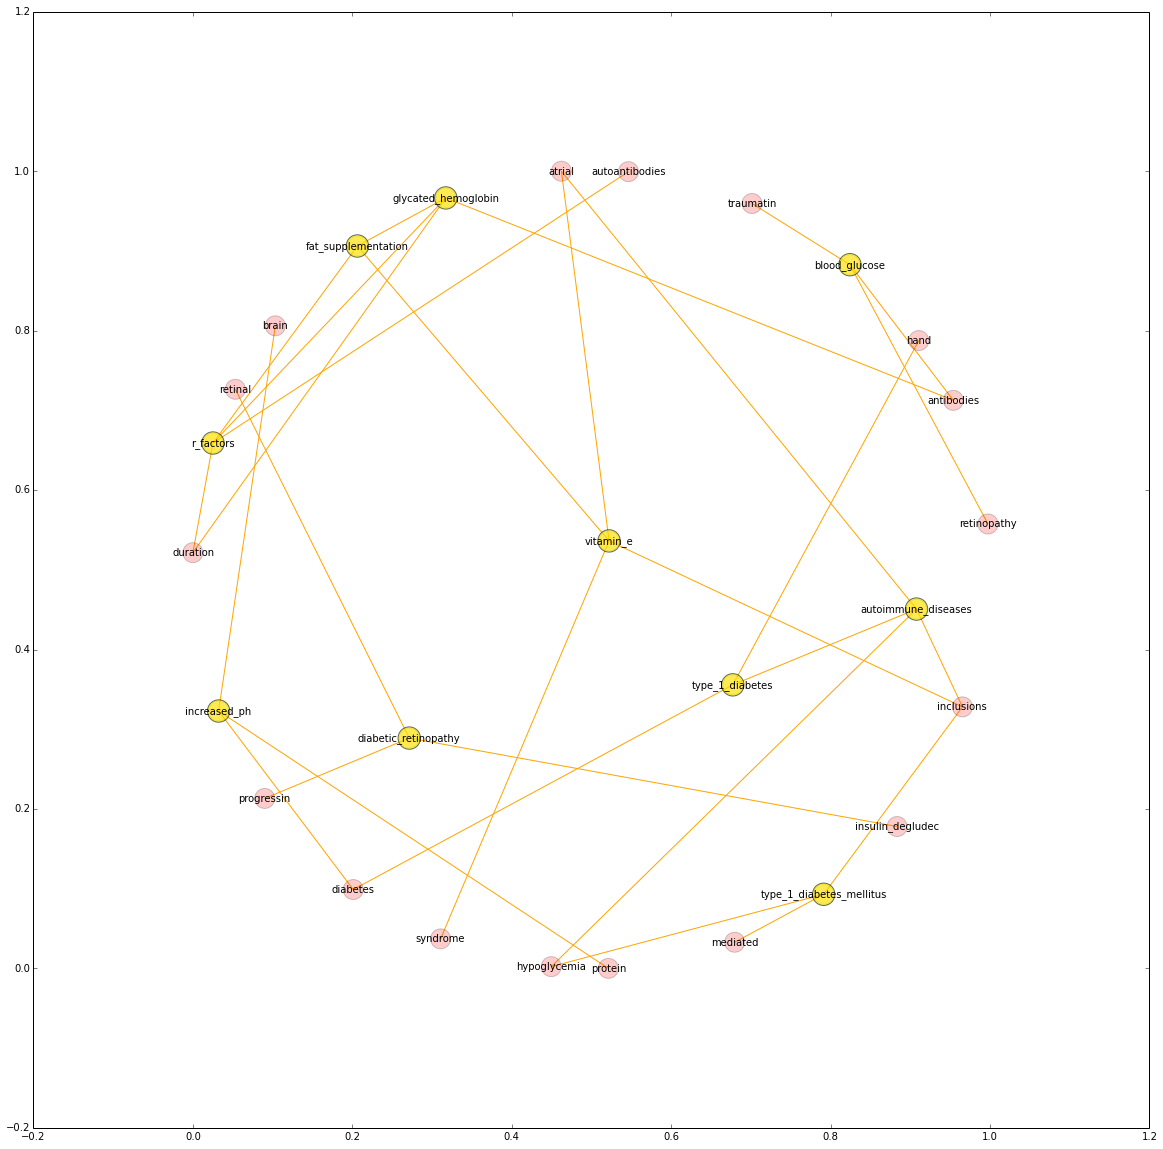

In [33]:
%matplotlib inline
import numpy as np
from pylab import *
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

def get_relevant_terms(term,cnt):
    synonyms=[]
    try:
        synonyms = model.findSynonyms(term, cnt) #get the most relevant cnt terms by computing vector distance
    except Exception as e:
        pass
    return synonyms

# construct the represeantion of the graph of concepts relationships derived from related terms obtained from word2vec
# by selecting the top 5 most relevant concepts where the releavncy is >0.5 for the most frequent diseases and drugs concepts
# having a frequency > 100 in the input 100 notes

import networkx as nx
G=nx.Graph()
d_d=set()

for termf in most_frequent_terms:
    term = termf[0]
    if ' ' not in term or termf[1]<2:
        continue
    rel = get_relevant_terms(term,3)
    for tup in rel:
        if tup[1]>0.1:
            G.add_edge(term.replace(' ','_'),tup[0].replace(' ','_'),weight=round(tup[1],2))
            d_d.add(term.replace(' ','_'))
            
d_d_l=list(d_d)
try: 
    pos = nx.spring_layout(G,iterations=100)
    plt.figure(figsize=(20,20))
    edgewidth = [ d['weight'] for (u,v,d) in G.edges(data=True)]
    nx.draw_networkx_nodes (G,pos,alpha=0.2,node_color='red',node_size=400)
    nx.draw_networkx_nodes (G,pos,alpha=0.6,nodelist=d_d_l,node_color='yellow',node_size=500)
    nx.draw_networkx_labels(G,pos,alpha=0.4,label_color='grey',font_size=10)
    nx.draw_networkx_edges(G,pos,edge_color='orange',width = 1)
    plt.savefig("disease_drugs.png")
    plt.show()
except Exception as e: # matplotlib not available
    print(e)